# Installs and Imports

In [1]:
!pip install -r requirements.txt

In [2]:
from collections import defaultdict
from math import sqrt

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import argmax, array, log
from numpy.random import rand, randn, choice
from tqdm import trange

# Helpers

In [3]:
def get_samples_from_normal_dist(n_samples_=10, mu=0, variance=1):
    return (sqrt(variance)*randn(n_samples_))+mu

# Bandit

In [128]:
class Bandit:
    def __init__(self, no_arms, reward_var = 1):
        self.no_arms = no_arms
        self.reward_var = reward_var
        # Initialises arm-means with normal distribution
        self.q_stars = get_samples_from_normal_dist(no_arms, mu=0, variance=self.reward_var)
        self.best_arm = argmax(self.q_stars)
        self.best_arms = self.q_stars.argsort()[-3:][::-1]
    def get_best_arm(self):
        return self.best_arm
    def get_rewards(self, arm, no_samples=1):
        # Returns rewards from normal distribution with
        # mean = arm_mean and variance = reward_var
        return get_samples_from_normal_dist(no_samples, mu=self.q_stars[arm], variance=self.reward_var)
    def plot(self, no_samples=2000, save_path=None):
        reward_set = []
        for arm_idx in range(self.no_arms):
            reward_set.append(self.get_rewards(arm_idx,no_samples))
        plt.figure(figsize=(15, 8))
        plt.violinplot(dataset=reward_set,showmeans=True)
        plt.xticks(list(range(1,self.no_arms+1)),list(range(self.no_arms)))
        plt.xlabel("Arm")
        plt.ylabel("Reward distribution")
        if save_path:
            plt.savefig(save_path)
        plt.show()
        plt.close()

# Algorithms

In [123]:
class EGreedy(Bandit):
    def __init__(self, no_arms, reward_var = 1, epsilon_=0):
        super(EGreedy,self).__init__(no_arms, reward_var)
        self.epsilon = epsilon_
        self.current_best_arm = (-1, 0)  # Best (arm, q_value) at any given time
        self.q_arms = defaultdict(float)  # Dict with Qa(t) value of arms(a) at any given time
        self.arms_count = defaultdict(int)  # Dict with number of times an arm has been pulled till any given time
        self.time = 0
        
    def pick_best_arm(self):
        # Returns random arm
        # - with probability epsilon or
        # - if this is t=1 and no best arm exists yet
        # Else, returns current best arm (computed based on Qa(t) value of arms)
        
        pick_determiner = rand()
        if pick_determiner<self.epsilon or (self.current_best_arm[0]==-1):
            return choice(self.no_arms)
        return self.current_best_arm[0]
    
    def update_current_best_arm(self, arm):
        # If chosen arm is same as best arm, just update the Qa(t) value in `current_best_arm` tuple
        # If Qa(t) of chosen arm is better than `current_best_arm`, chosen arm becomes `current_best_arm` 
        
        if self.current_best_arm[0] == arm or (self.current_best_arm[1]< self.q_arms[arm]):
            self.current_best_arm = (arm, self.q_arms[arm])
    
    def update_values(self, arm, reward):
        # Update self.arms_count
        self.arms_count[arm] += 1
        # Update q_arms
        self.q_arms[arm] += (reward - self.q_arms[arm]) / self.arms_count[arm]
        # Update self.current_best_arm
        self.update_current_best_arm(arm)
        
    def run(self, time_instances=1000):
        rewards_obtained = []
        is_opt_action = []
        while self.time < time_instances:
            self.time += 1
            chosen_arm = self.pick_best_arm()  # Choose arm
            if self.time == 11: # and chosen_arm==self.best_arm:
                print(f"I choose : {chosen_arm}; best arm : {self.best_arm}")
            reward = self.get_rewards(chosen_arm)[0]  # Get reward
#             print(f"I got {reward}")
            rewards_obtained.append(reward)
            is_opt_action.append(1 if chosen_arm==self.best_arm else 0)
            self.update_values(chosen_arm, reward)  # Update Qa(t) and other state values
#             print(f"Q values : {self.q_arms}")
        # Returns 2 lists of length of `time_instances`
        # - rewards obtained at each time_instance
        # - Arm pulled at each time instance is the optimal arm of the bandit (Yes:1; No:0)
        return rewards_obtained, is_opt_action 

In [124]:
class UCB(EGreedy):
    def __init__(self, no_arms, reward_var = 1, ucb_confidence_ = 0.1):
        super(UCB,self).__init__(no_arms, reward_var, None)
        self.ucb_confidence = ucb_confidence_  # Confidence value `c`
        
    def pick_best_arm(self):
        if self.current_best_arm[0]==-1:
            return choice(self.no_arms)
        return self.current_best_arm[0]
    
    def update_current_best_arm(self, arm):
        # `current_best_arm` is updated by computing UCB for all arms at current time instance and
        # choosing the one with optimal value
        ucb_estimations = []
        for arm_ in range(self.no_arms):
            ucb_estimations.append(self.q_arms[arm_] + \
            self.ucb_confidence * sqrt(log(self.time + 1) / (self.arms_count[arm_] + 1e-5)))
        current_max_arm = argmax(ucb_estimations)
        self.current_best_arm = (current_max_arm,)

In [127]:
ucb_bandit = UCB(10, 1, ucb_confidence_= 1)
ucb_bandit.run(time_instances=11)

I got 0.17191696306266524
Q values : defaultdict(<class 'float'>, {5: 0.17191696306266524, 0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0})
I got -1.3706347771692213
Q values : defaultdict(<class 'float'>, {5: 0.17191696306266524, 0: -1.3706347771692213, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0})
I got -2.5937766382755525
Q values : defaultdict(<class 'float'>, {5: 0.17191696306266524, 0: -1.3706347771692213, 1: -2.5937766382755525, 2: 0.0, 3: 0.0, 4: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0})
I got -1.2659409003974036
Q values : defaultdict(<class 'float'>, {5: 0.17191696306266524, 0: -1.3706347771692213, 1: -2.5937766382755525, 2: -1.2659409003974036, 3: 0.0, 4: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0})
I got 1.154263982351157
Q values : defaultdict(<class 'float'>, {5: 0.17191696306266524, 0: -1.3706347771692213, 1: -2.5937766382755525, 2: -1.2659409003974036, 3: 1.154263982351157, 4: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0})
I got 0.0251281504836147

([0.17191696306266524,
  -1.3706347771692213,
  -2.5937766382755525,
  -1.2659409003974036,
  1.154263982351157,
  0.025128150483614706,
  2.097985218108595,
  -0.4440597323509181,
  2.185934673961407,
  -0.1207579359666553,
  1.475388137135385],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [118]:
rewards_coll = []
for _ in range(2000):
    ucb_bandit = UCB(10, 1, ucb_confidence_= 1)
    rewards_coll.append(ucb_bandit.run(time_instances=20)[0])
# plt.plot(range(20),array(rewards_coll).mean(axis=0))

I choose : 5; best arm : 5
I choose : 1; best arm : 1
I choose : 7; best arm : 7
I choose : 0; best arm : 0
I choose : 6; best arm : 6
I choose : 1; best arm : 1
I choose : 4; best arm : 4
I choose : 9; best arm : 9
I choose : 9; best arm : 9
I choose : 5; best arm : 5
I choose : 1; best arm : 1
I choose : 0; best arm : 0
I choose : 8; best arm : 8
I choose : 5; best arm : 5
I choose : 8; best arm : 8
I choose : 0; best arm : 0
I choose : 9; best arm : 9
I choose : 6; best arm : 6
I choose : 8; best arm : 8
I choose : 6; best arm : 6
I choose : 6; best arm : 6
I choose : 2; best arm : 2
I choose : 4; best arm : 4
I choose : 6; best arm : 6
I choose : 8; best arm : 8
I choose : 1; best arm : 1
I choose : 7; best arm : 7
I choose : 1; best arm : 1
I choose : 0; best arm : 0
I choose : 0; best arm : 0
I choose : 4; best arm : 4
I choose : 0; best arm : 0
I choose : 8; best arm : 8
I choose : 8; best arm : 8
I choose : 9; best arm : 9
I choose : 2; best arm : 2
I choose : 8; best arm : 8
I

I choose : 4; best arm : 4
I choose : 0; best arm : 0
I choose : 7; best arm : 7
I choose : 2; best arm : 2
I choose : 3; best arm : 3
I choose : 2; best arm : 2
I choose : 8; best arm : 8
I choose : 3; best arm : 3
I choose : 1; best arm : 1
I choose : 9; best arm : 9
I choose : 3; best arm : 3
I choose : 6; best arm : 6
I choose : 8; best arm : 8
I choose : 0; best arm : 0
I choose : 5; best arm : 5
I choose : 4; best arm : 4
I choose : 2; best arm : 2
I choose : 1; best arm : 1
I choose : 2; best arm : 2
I choose : 6; best arm : 6
I choose : 0; best arm : 0
I choose : 7; best arm : 7
I choose : 3; best arm : 3
I choose : 3; best arm : 3
I choose : 0; best arm : 0
I choose : 1; best arm : 1
I choose : 5; best arm : 5
I choose : 7; best arm : 7
I choose : 1; best arm : 1
I choose : 2; best arm : 2
I choose : 0; best arm : 0
I choose : 7; best arm : 7
I choose : 2; best arm : 2
I choose : 6; best arm : 6
I choose : 7; best arm : 7
I choose : 9; best arm : 9
I choose : 2; best arm : 2
I

I choose : 0; best arm : 0
I choose : 1; best arm : 1
I choose : 7; best arm : 7
I choose : 7; best arm : 7
I choose : 5; best arm : 5
I choose : 6; best arm : 6
I choose : 8; best arm : 8
I choose : 7; best arm : 7
I choose : 7; best arm : 7
I choose : 3; best arm : 3
I choose : 7; best arm : 7
I choose : 7; best arm : 7
I choose : 0; best arm : 0
I choose : 3; best arm : 3
I choose : 8; best arm : 8
I choose : 2; best arm : 2
I choose : 6; best arm : 6
I choose : 8; best arm : 8
I choose : 2; best arm : 2
I choose : 5; best arm : 5
I choose : 5; best arm : 5
I choose : 9; best arm : 9
I choose : 1; best arm : 1
I choose : 8; best arm : 8
I choose : 3; best arm : 3
I choose : 6; best arm : 6
I choose : 8; best arm : 8
I choose : 3; best arm : 3
I choose : 7; best arm : 7
I choose : 0; best arm : 0
I choose : 8; best arm : 8
I choose : 0; best arm : 0
I choose : 2; best arm : 2
I choose : 9; best arm : 9
I choose : 9; best arm : 9
I choose : 8; best arm : 8
I choose : 2; best arm : 2
I

In [117]:
array(rewards_coll).mean(axis=0)

array([ 0.15802072, -0.01835598, -0.09394693, -0.0027729 ,  0.01996739,
        0.10159169, -0.05436261, -0.10555222,  0.03756324,  0.1014716 ,
        1.02363246,  1.07263946,  0.95059926,  1.07336662,  0.98205357,
        1.04770539,  1.1118116 ,  1.23060219,  0.97959354,  1.27417447])

# Experiment

In [7]:
class Experiment:
    def __init__(self, no_arms, time_instances, no_runs,
                 reward_variance_list, epsilon_list, ucb_conf_list,
                 plot_save_path):
        self.no_arms = no_arms  # Number of arms in the bandit
        self.time_instances = time_instances  # No of steps to run each bandit
        self.no_runs = no_runs  # No of times experiment to be run for averaging
        self.reward_variance_list = reward_variance_list  # List of reward variances to experiment
        self.epsilon_list = epsilon_list  # List of epsilons for Epsilon-bandit
        self.ucb_conf_list = ucb_conf_list  # List of `c` values for UCB
        self.plot_save_path = plot_save_path  # Path to save the plots
       
    @staticmethod
    def add_plots(data, legend_label, y_label, title_):
        plt.plot(data, label=legend_label)
        plt.title(title_)
        plt.xlabel('steps')
        plt.ylabel(y_label)
        plt.legend() 
        
    def simulate_single_exp(self, reward_var = 1, epsilon=0, ucb_confidence=None):
        # Creates `no_runs` instances of bandit
        # Type of bandit determined with provided parameters
        avg_rewards_coll = []
        rewards_coll = []
        is_opt_coll = []
        for _ in trange(self.no_runs):
            if ucb_confidence:
                selected_bandit = UCB(self.no_arms, reward_var, ucb_confidence_= ucb_confidence)
            else:
                selected_bandit = EGreedy(self.no_arms, reward_var, epsilon_=epsilon)
            rewards, is_opt = selected_bandit.run(self.time_instances)
            rewards_coll.append(rewards)
            is_opt_coll.append(is_opt)
        # Returns Average reward and percentage of optimal actions,
        # averaging across `no_runs` instances for each time_instance
        return array(rewards_coll).mean(axis=0), array(is_opt_coll).mean(axis=0)*100
    
    def run(self):
        # Loops for all reward-variances
        for reward_variance in self.reward_variance_list:
            print("===============================================")
            
            # -------------- Simulating --------------
            print(f"Simultion for Reward Variance:{reward_variance}")
            average_reward_collection = []
            optimal_action_collection = []
            for eps in self.epsilon_list:
                print(f"Simulating for epsilon {eps}")
                rew_coll, per_opt_coll = self.simulate_single_exp(reward_var=reward_variance,
                                                                  epsilon=eps)
                average_reward_collection.append((rew_coll,'epsilon = %.02f' % (eps)))
                optimal_action_collection.append((per_opt_coll,'epsilon = %.02f' % (eps)))
            for ucb_conf in self.ucb_conf_list:
                print(f"Simulating for UCB confidence {ucb_conf}")
                rew_coll, per_opt_coll = self.simulate_single_exp(reward_var=reward_variance,
                                                                  ucb_confidence=ucb_conf)
                average_reward_collection.append((rew_coll,'UCB = %.02f' % (ucb_conf)))
                optimal_action_collection.append((per_opt_coll,'UCB = %.02f' % (ucb_conf)))
                
            # -------------- Plotting --------------
            plt.figure(figsize=(10, 20))
            plt.subplot(2, 1, 1)
            for rewards, legend_label in average_reward_collection:
                self.add_plots(rewards,legend_label,'average reward', "Awerage Reward vs Steps")
            plt.subplot(2, 1, 2)
            for counts, legend_label in optimal_action_collection:
                self.add_plots(counts,legend_label,'% optimal action', "Optimal Action Percentage vs Steps")
            if self.plot_save_path:
                plt.savefig(self.plot_save_path.format(f"variance_{reward_variance}"))
            plt.show()
            plt.close()
            print("===============================================")

# Simulations and plots

### Bandit with reward-variance = 1

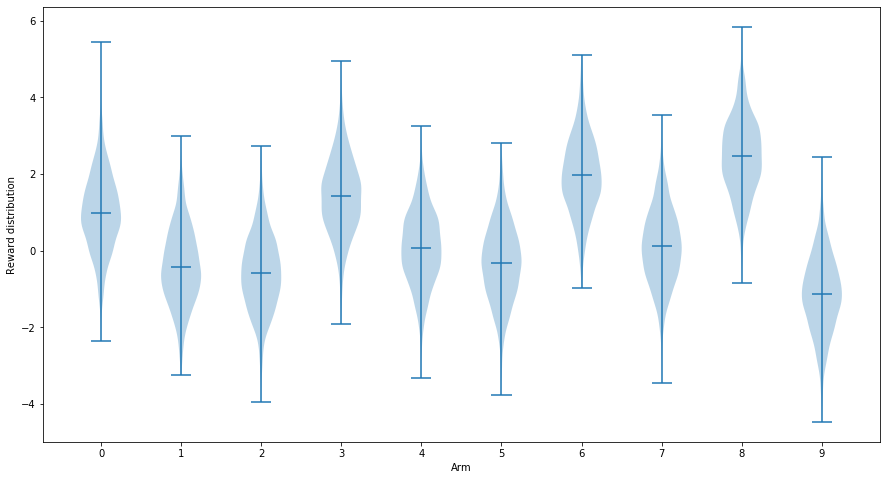

Optimal Arm is 8


In [122]:
bandit_var1 = Bandit(10, reward_var=1)
bandit_var1.plot(save_path="10_arms_bandit_variance_1_reward_dist.png")
print(f"Optimal Arm is {bandit_var1.get_best_arm()}")

### Bandit with variance = 10

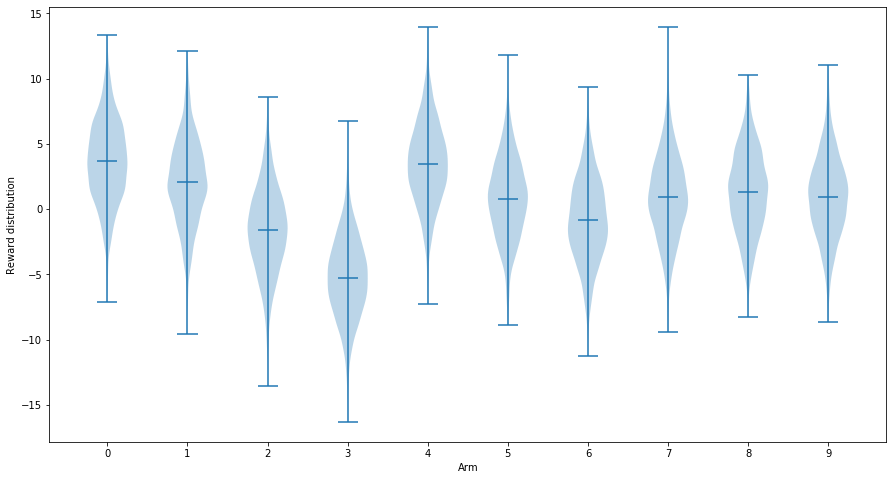

Optimal Arm is 0


In [9]:
bandit_var10 = Bandit(10, reward_var=10)
bandit_var10.plot(save_path="10_arms_bandit_variance_10_reward_dist.png")
print(f"Optimal Arm is {bandit_var10.get_best_arm()}")

### Average reward and % optimal action plots for multiple variances

In [10]:
experiment = Experiment(no_arms=10, time_instances=1000, no_runs=2000,
                        reward_variance_list= [1,10],
                        epsilon_list=[0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.9],
                        ucb_conf_list=[0.1, 0.5, 1, 2, 3, 5, 10],
                        plot_save_path="10_arms_bandit_{}_comparisons.png")

  1%|          | 16/2000 [00:00<00:12, 153.67it/s]

Simultion for Reward Variance:1
Simulating for epsilon 0


  1%|          | 17/2000 [00:00<00:12, 164.27it/s]

Simulating for epsilon 0.01


  1%|▏         | 25/2000 [00:00<00:16, 118.31it/s]

Simulating for epsilon 0.05


  1%|          | 13/2000 [00:00<00:16, 122.76it/s]

Simulating for epsilon 0.1


  1%|          | 20/2000 [00:00<00:21, 93.85it/s]

Simulating for epsilon 0.2


  1%|          | 11/2000 [00:00<00:19, 102.33it/s]

Simulating for epsilon 0.3


  0%|          | 10/2000 [00:00<00:22, 90.00it/s]

Simulating for epsilon 0.5


  0%|          | 6/2000 [00:00<00:37, 52.52it/s]

Simulating for epsilon 0.9


  0%|          | 4/2000 [00:00<00:54, 36.94it/s]

Simulating for UCB confidence 0.1


  0%|          | 4/2000 [00:00<01:02, 31.77it/s]

Simulating for UCB confidence 0.5


  0%|          | 8/2000 [00:00<01:02, 31.76it/s]

Simulating for UCB confidence 1


  0%|          | 3/2000 [00:00<01:10, 28.51it/s]

Simulating for UCB confidence 2


  0%|          | 4/2000 [00:00<00:58, 34.40it/s]

Simulating for UCB confidence 3


  0%|          | 4/2000 [00:00<00:56, 35.15it/s]

Simulating for UCB confidence 5


  0%|          | 4/2000 [00:00<00:57, 34.49it/s]

Simulating for UCB confidence 10


100%|██████████| 2000/2000 [00:59<00:00, 33.53it/s]


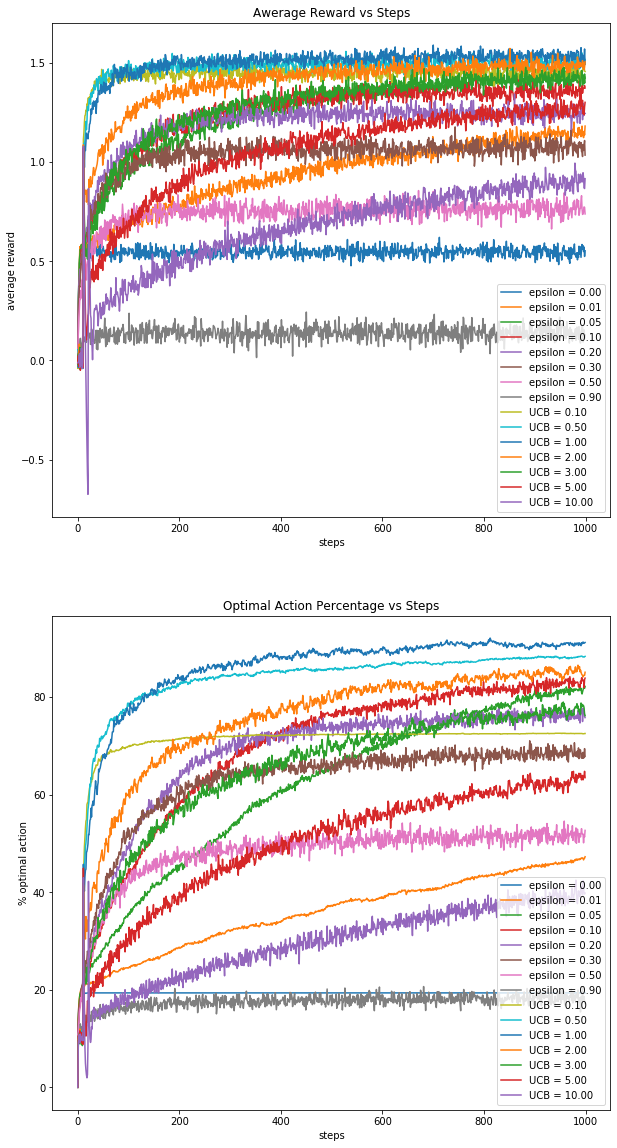

  1%|▏         | 29/2000 [00:00<00:14, 136.22it/s]

Simultion for Reward Variance:10
Simulating for epsilon 0


  2%|▏         | 32/2000 [00:00<00:12, 157.55it/s]

Simulating for epsilon 0.01


  1%|▏         | 25/2000 [00:00<00:15, 125.05it/s]

Simulating for epsilon 0.05


  1%|          | 14/2000 [00:00<00:14, 132.58it/s]

Simulating for epsilon 0.1


  1%|          | 11/2000 [00:00<00:18, 107.48it/s]

Simulating for epsilon 0.2


  1%|          | 11/2000 [00:00<00:18, 104.80it/s]

Simulating for epsilon 0.3


  0%|          | 9/2000 [00:00<00:23, 85.86it/s]

Simulating for epsilon 0.5


  0%|          | 7/2000 [00:00<00:30, 64.92it/s]

Simulating for epsilon 0.9


  0%|          | 4/2000 [00:00<00:57, 34.72it/s]

Simulating for UCB confidence 0.1


  0%|          | 4/2000 [00:00<00:57, 34.49it/s]

Simulating for UCB confidence 0.5


  0%|          | 4/2000 [00:00<00:57, 34.72it/s]

Simulating for UCB confidence 1


  0%|          | 4/2000 [00:00<00:57, 34.76it/s]

Simulating for UCB confidence 2


  0%|          | 4/2000 [00:00<00:58, 33.90it/s]

Simulating for UCB confidence 3


  0%|          | 4/2000 [00:00<00:57, 34.64it/s]

Simulating for UCB confidence 5


  0%|          | 4/2000 [00:00<00:56, 35.08it/s]

Simulating for UCB confidence 10


100%|██████████| 2000/2000 [00:59<00:00, 33.60it/s]


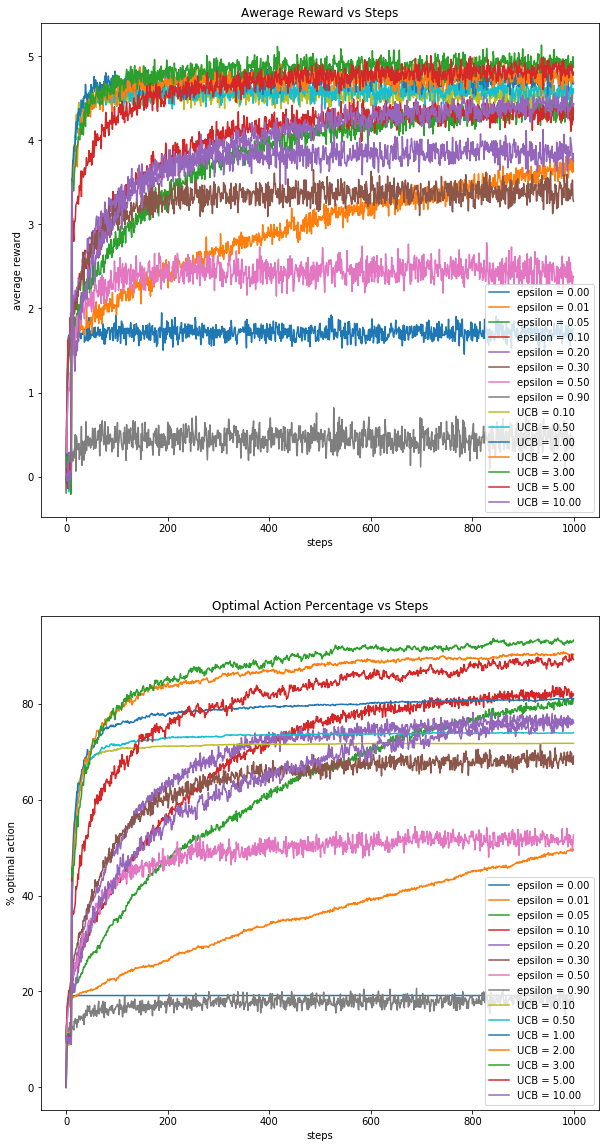

In [11]:
experiment.run()

### Study and Inferences

#### 1. Comparison between different epsilon values

  1%|          | 15/2000 [00:00<00:13, 142.89it/s]

Simultion for Reward Variance:1
Simulating for epsilon 0


  2%|▏         | 30/2000 [00:00<00:13, 147.12it/s]

Simulating for epsilon 0.01


  1%|          | 14/2000 [00:00<00:14, 138.18it/s]

Simulating for epsilon 0.05


  1%|          | 14/2000 [00:00<00:14, 134.80it/s]

Simulating for epsilon 0.1


  1%|          | 12/2000 [00:00<00:17, 113.46it/s]

Simulating for epsilon 0.2


  1%|          | 11/2000 [00:00<00:19, 101.63it/s]

Simulating for epsilon 0.3


  0%|          | 9/2000 [00:00<00:24, 82.01it/s]

Simulating for epsilon 0.5


  0%|          | 7/2000 [00:00<00:29, 67.18it/s]

Simulating for epsilon 0.9


100%|██████████| 2000/2000 [00:31<00:00, 63.67it/s]


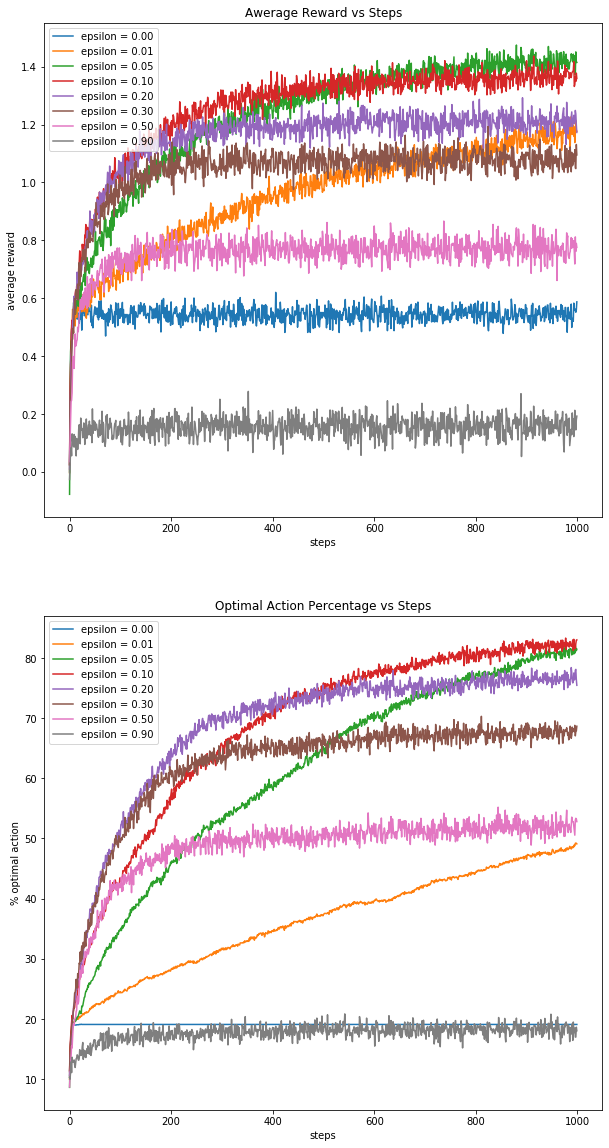

In [12]:
experiment = Experiment(no_arms=10, time_instances=1000, no_runs=2000,
                        reward_variance_list= [1],
                        epsilon_list=[0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.9],
                        ucb_conf_list=[],
                        plot_save_path=None)
experiment.run()

**Observations**
- Episilon value falls in the range \[0,1); Epsilon=0 being pure-greedy aprroach
- _**Lower values of Epsilon (0, 0.01)**_ denotes less importance given to exploration and more weightage to exploitation
: Thus, we rarely get optimal-rewards, leading to average rewards being minimal, sticking to optimum values obtained in first few runs.
- _**Higher values of Epsilon (0.90, 0.50)**_ denotes more importance to exploration and less of exploitation of already found optimum value
: Thus, we get minimal average rewards again, as we don't exploit the obtained optimal value long enough.
- _**Optimal values of Epsilon lie in range of [0.05, 0.03]**_ where optimal action is chosen > 60\% of the times and average reward obtained is also relatively higher.
- We specifically notice _**Epsilon values 0.05 and 0.10**_ being ideal as they obtain maximum reward and with iterations, choose 80\% of time optimal action.
    - We also note that, _**Epsilon=0.10**_ reaches optimal value with less number of iterations than _**Epsilon=0.05**_. Yet, average rewards obtained by _**Epsilon=0.05**_ over long run seems more profittable than _**Epsilon=0.10**_.

#### 2. Comparison between different UCB confidence values

  0%|          | 4/2000 [00:00<01:00, 32.83it/s]

Simultion for Reward Variance:1
Simulating for UCB confidence 0.1


  0%|          | 4/2000 [00:00<01:01, 32.68it/s]

Simulating for UCB confidence 0.5


  0%|          | 4/2000 [00:00<00:56, 35.29it/s]

Simulating for UCB confidence 1


  0%|          | 8/2000 [00:00<01:00, 32.72it/s]

Simulating for UCB confidence 2


  0%|          | 4/2000 [00:00<00:56, 35.48it/s]

Simulating for UCB confidence 3


  0%|          | 4/2000 [00:00<00:59, 33.77it/s]

Simulating for UCB confidence 5


  0%|          | 4/2000 [00:00<00:57, 34.85it/s]

Simulating for UCB confidence 10


100%|██████████| 2000/2000 [00:59<00:00, 33.68it/s]


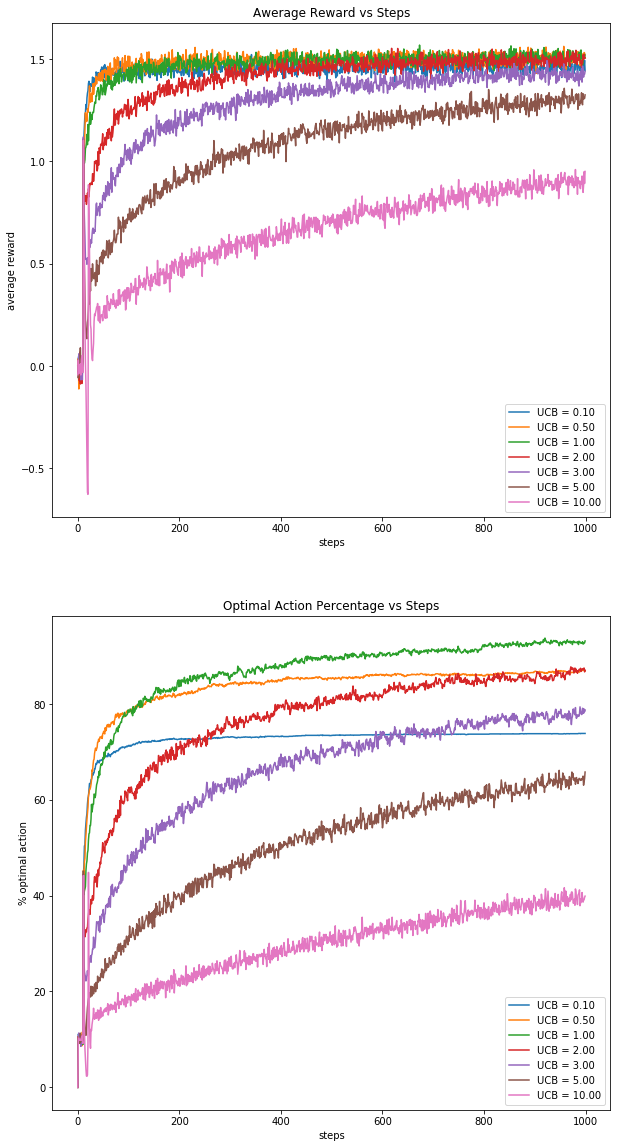

In [13]:
experiment = Experiment(no_arms=10, time_instances=1000, no_runs=2000,
                        reward_variance_list= [1],
                        epsilon_list=[],
                        ucb_conf_list=[0.1, 0.5, 1, 2, 3, 5, 10],
                        plot_save_path=None)
experiment.run()

**Observations**
- _**c**_ is a value >0, determining the confidence level of variance component of action's estimate. It controls the degree of exploration.
- With lower values of _**c (<=1.00)**_, they reach the optimal value with less iterations and stabilize. This is because of balanced exploration- giving slight higher weightage to less explored actions.
- With increase in value of _**c (>= 2.0)**_, we see a degradation in both average reward and percentage of times optimal action is chosen.This is because increasing weightage for exploration imbalances exploitation of optimal value.
- In this experiment (and more generally), _**c=1.0**_ looks like an optimal value.

#### 3. Comparison between E-Greedy and UCB 

  1%|          | 13/2000 [00:00<00:15, 128.23it/s]

Simultion for Reward Variance:1
Simulating for epsilon 0.1


  0%|          | 4/2000 [00:00<00:58, 34.34it/s]

Simulating for UCB confidence 2


100%|██████████| 2000/2000 [00:59<00:00, 33.58it/s]


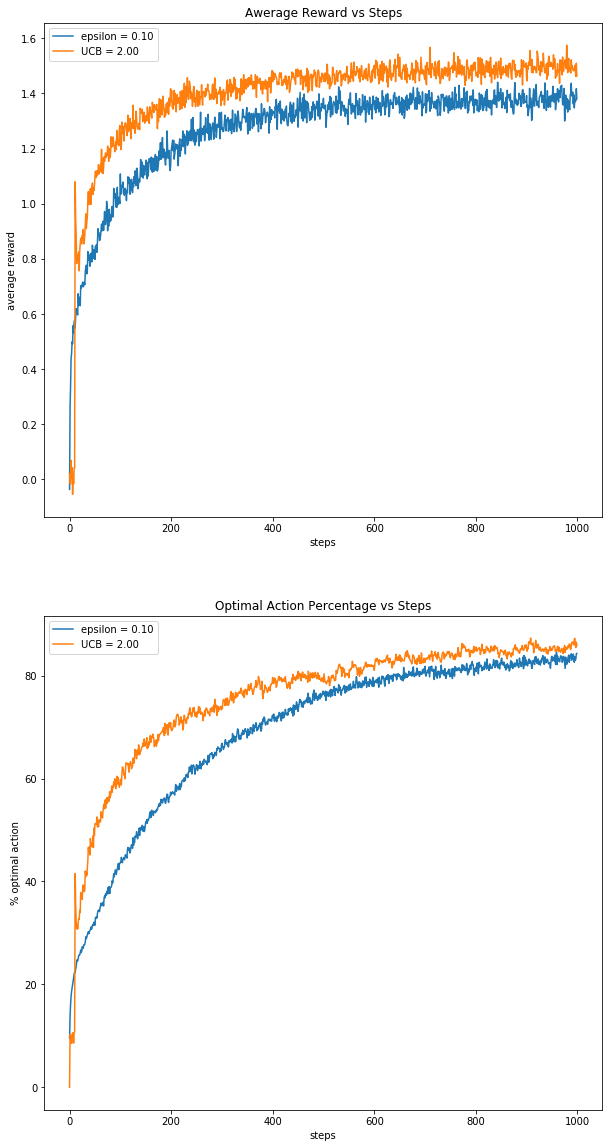

In [14]:
experiment = Experiment(no_arms=10, time_instances=1000, no_runs=2000,
                        reward_variance_list= [1],
                        epsilon_list=[0.1],
                        ucb_conf_list=[2],
                        plot_save_path=None)
experiment.run()

**Observations**
- _**UCB**_ performs better than _**Epsilon-Greedy**_ as it supports more balanced exploration of actions - giving importance to less explored actions. Whereas, _**Epsilon-Greedy**_ performs exploration in an indiscrimate fashion.
- We notice a spike at step **11** of UCB and then a dip because
    - For first 10 steps, 10 bandits are chosen one after the other, as `Nt(a)` of these will be 0 and hence being the maximising action.
    - At the 11th step, for all actions `ln(t)` and `Nt(a)` will be same and optimal action will be chosen based on `Qt(a)` of all actions. This will be the best value till 11th step. Hence, the spike.
    - After 11th step, again average reward will have a dip as bandits are no longer equally explored / picked, but picked on a weighted fashion.

#### 4. Comparison between different variances

  1%|          | 12/2000 [00:00<00:17, 116.58it/s]

Simultion for Reward Variance:1
Simulating for epsilon 0.1


100%|██████████| 2000/2000 [00:15<00:00, 128.66it/s]


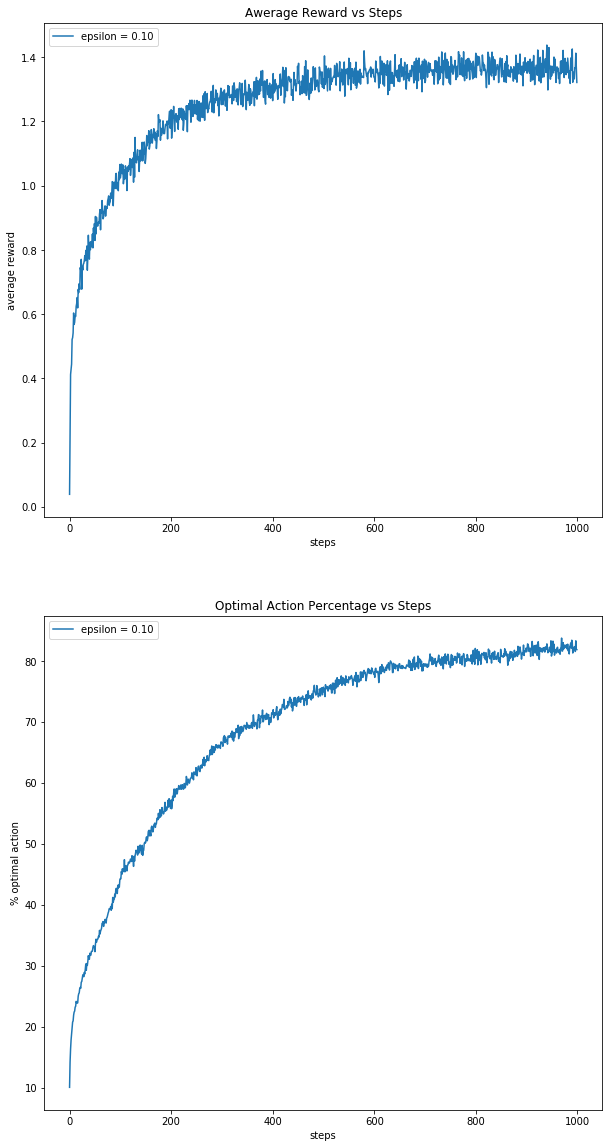

  1%|          | 13/2000 [00:00<00:15, 126.90it/s]

Simultion for Reward Variance:10
Simulating for epsilon 0.1


100%|██████████| 2000/2000 [00:15<00:00, 127.63it/s]


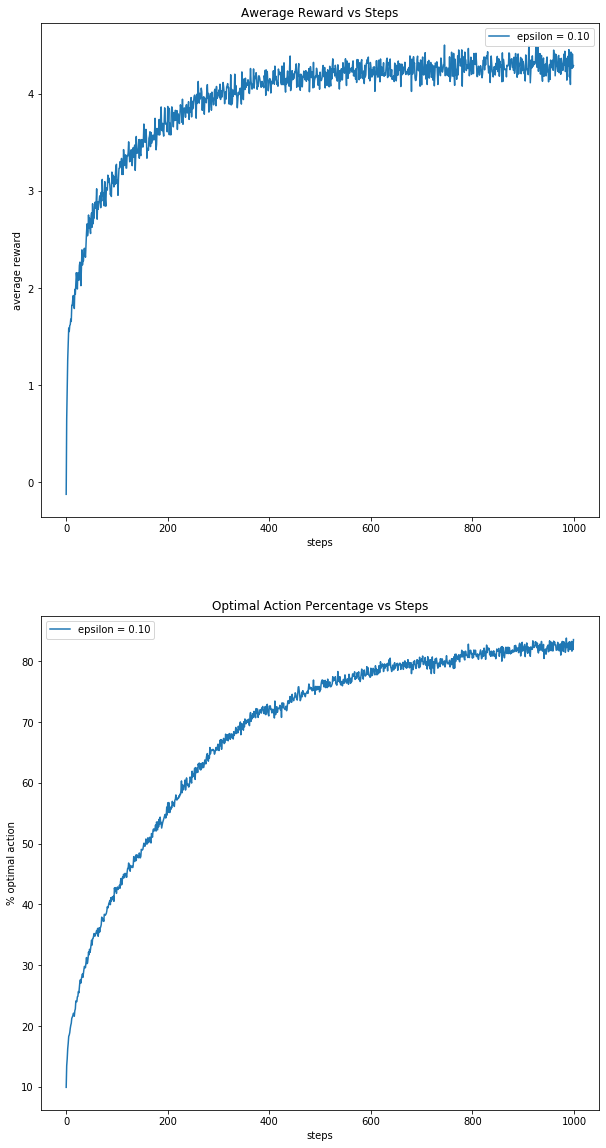

In [15]:
experiment = Experiment(no_arms=10, time_instances=1000, no_runs=2000,
                        reward_variance_list= [1,10],
                        epsilon_list=[0.1],
                        ucb_conf_list=[],
                        plot_save_path=None)
experiment.run()

**Observations**
- With increase in variance of rewards, more exploration might be required to find the optimal action. Hence, we might need more iterations to achieve an optimal convergence.